## ING Datathon 2018 - Kernel

* Orhan İştenhiçkorkmaz, https://github.com/orhaneee
* Model was created with gradient boosting algorithms and implemented on both [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [XGBoost](https://xgboost.readthedocs.io/en/latest/).
* The data was imbalanced so, I need `upsampling` on data with SMOTE (Synthetic Minority Over-sampling Technique)

In [1]:
!which pip
!which python

/c/Users/orhan/Anaconda2/Scripts/pip
/c/Users/orhan/Anaconda2/python


In [2]:
# Required packages that do not come preinstalled with Anaconda

!pip install xgboost
!pip install lightgbm
!pip install seaborn
!pip install imbalanced-learn

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
grin 1.2.1 requires argparse>=1.1, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
grin 1.2.1 requires argparse>=1.1, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
grin 1.2.1 requires argparse>=1.1, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
grin 1.2.1 requires argparse>=1.1, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import pickle

Observe time required for CPU to read .csv file

In [4]:
%%time

# CSV file is seperated by ';' not ','
df_data = pd.read_csv('./INGDatathonData/INGDatathonData2018.csv', delimiter=';')

Wall time: 4.12 s


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Columns: 682 entries, PRIMARY_KEY to TTL_TL_LMT_UTLZTN_DNM_FRK12
dtypes: float64(680), int64(2)
memory usage: 193.7 MB


Checking dependent variable `DEFAULT_FLAG` count and see whether this data is `balanced` or `imbalanced`
* Good info about imbalanced datas' disadvantages can be found on this [link](http://www.chioka.in/class-imbalance-problem/)
* After all, I will try to fix imbalance issue with hyperparameters of XGBoost, which can also be found on XGBoost [docs](https://xgboost.readthedocs.io/en/latest/parameter.html).

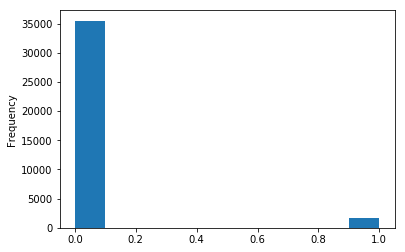

In [6]:
# Plotting histogram of value counts.
df_data['DEFAULT_FLAG'].astype(int).plot.hist()

## Feature Engineering and EDA

I always start with checking null percentage on each column.

In [7]:
# Function to create a table of missing value percentage and counts.

def calculate_missing_values(df):
    # Total missing values
    total_missing = df.isnull().sum()
    percentage = (total_missing * 100) / len(df)
    # Create a table for visualizing.
    table = pd.concat([total_missing, percentage], axis=1)
    renamed_columns = table.rename(
        columns = { 0 : 'missing values', 1 : '% of total' }
    )
    # Sorting the table.
    renamed_columns = renamed_columns[
        renamed_columns.iloc[:, 1] != 0
    ].sort_values(
        '% of total', ascending=False
    ).round(1)
    return renamed_columns

In [8]:
missing_value_table = calculate_missing_values(df_data)
missing_value_table.head(50)

,missing values,% of total
STDDEV_TTL_FX_NON_CASH_RSK12,37199,99.9
STDDEV_FX_OR_FX_NON_UTIL12,37199,99.9
STDDEV_TTL_ACCRD_INT_AMT12,37082,99.6
STDDEV_FACTORING_RSK12,37078,99.6
STDDEV_FACTORING_TL_RSK12,37078,99.6
STDDEV_TTL_FX_NON_CSH_LIMIT12,36623,98.4
FX_OR_FX_NON_UTIL_GR12,36619,98.4
SHR_FX_OR_INDX_FCT_RSK_TTL_RSK,36450,97.9
SHARE_OF_TL_FACTORING_RISK,36450,97.9
FX_OR_FX_NON_UTIL_GR6,36398,97.8


### One Hot Encoding

Since, we do not have any categorical variable column, i.e we saw it on `df_data.info()` that all fields are either float or int 64 bit. So, we do not need to encode our categorical variables.

### Correlations

In [9]:
%%time

# Find correlations between each columns
corr_matrix = df_data.corr().abs()
# Get upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print('There are %d correlated columns.' % (len(to_drop)))

df_data = df_data.drop(columns=to_drop)
print(df_data.shape)

There are 533 correlated columns.
(37224, 149)
Wall time: 1min 18s


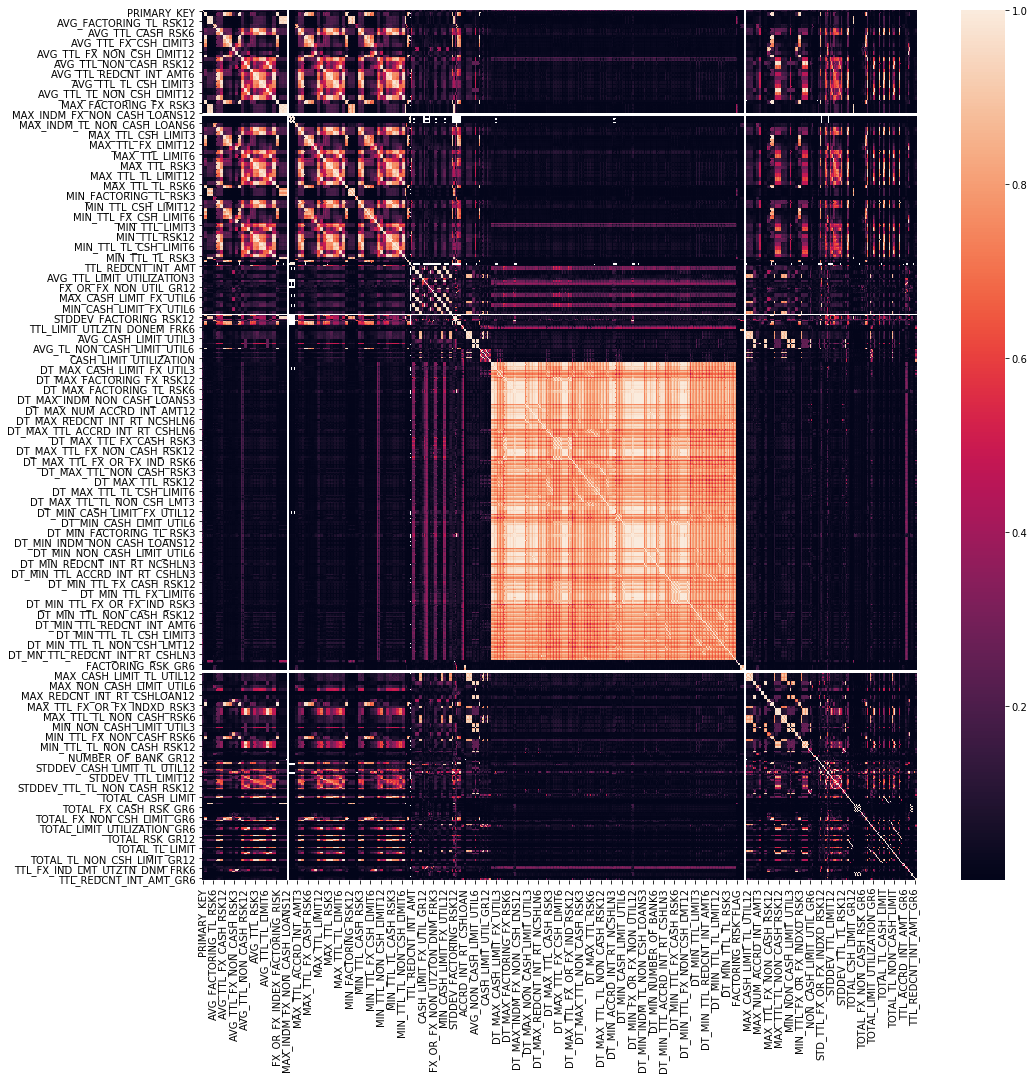

In [10]:
# Used this line to show heatmap bigger
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(corr_matrix.abs())

## Feature Selection

I think that applied machine (or deep) learning problems are all about feature selection. First, analyze the data but no too much in order to avoid overfitting.

The heatmap above tells me that:
* Not a single feature is correlated completely with class.
* Model requires the combination of features.

### Removing missing values

Removing missing values higher than a threshold is a simple feature selection technique. As we know, other most used ones are Principal Component Analysis, Recursive Feature Elimination and Feature Importance (just for tree based algorithms). In the upper cells, I showed a little bit info about missing values and percentage.

So, I will apply this firstly.

In [11]:
missing_columns = (df_data.isnull().sum() / len(df_data)).sort_values(ascending = False)
missing_columns.head(20)

STDDEV_FX_OR_FX_NON_UTIL12        0.999328
FX_OR_FX_NON_UTIL_GR12            0.983747
SHARE_OF_TL_FACTORING_RISK        0.979207
SHR_FX_OR_INDX_FCT_RSK_TTL_RSK    0.979207
FX_OR_FX_NON_UTIL_GR6             0.977810
AVG_FX_OR_FX_NON_UTIL12           0.969992
FX_OR_FX_NON_UTZTN_DNM_FRK6       0.961638
FX_OR_FX_NON_UTZTON_DNM_FRK3      0.961638
FX_OR_FX_NON_UTZTTN_DNM_FRK12     0.961638
CASH_LIMIT_FX_UTIL_GR12           0.930663
CASH_LIMIT_FX_UTIL_GR6            0.840640
AVG_CASH_LIMIT_FX_UTIL12          0.753707
TOTAL_LIMIT_UTILIZATION_GR12      0.728374
STDDEV_TTL_LIMIT_UTILIZATION12    0.724156
STD_TL_NON_CASH_LIMIT_UTIL12      0.671690
CASH_LIMIT_FX_UTLZTN_DNM_FRK3     0.668843
CASH_LIMIT_FX_UTLZTN_DNM_FRK6     0.668816
CASH_LMT_FX_UTLZTN_DNM_FRK12      0.668816
NON_CASH_LIMIT_UTIL_GR12          0.584193
STDDEV_TTL_NON_CSH_LIMIT12        0.568665
dtype: float64

In [12]:
missing_columns = missing_columns.index[missing_columns > 0.75]
print(missing_columns)

Index([u'STDDEV_FX_OR_FX_NON_UTIL12', u'FX_OR_FX_NON_UTIL_GR12',
       u'SHARE_OF_TL_FACTORING_RISK', u'SHR_FX_OR_INDX_FCT_RSK_TTL_RSK',
       u'FX_OR_FX_NON_UTIL_GR6', u'AVG_FX_OR_FX_NON_UTIL12',
       u'FX_OR_FX_NON_UTZTN_DNM_FRK6', u'FX_OR_FX_NON_UTZTON_DNM_FRK3',
       u'FX_OR_FX_NON_UTZTTN_DNM_FRK12', u'CASH_LIMIT_FX_UTIL_GR12',
       u'CASH_LIMIT_FX_UTIL_GR6', u'AVG_CASH_LIMIT_FX_UTIL12'],
      dtype='object')


In [13]:
df_data = df_data.drop(columns=missing_columns)

In [14]:
df_data.shape

(37224, 137)

### Keep Most Important Features

In many large datasets, building a model with a gradient boosting algorithm, we need to remove 0 important features in order to increase performance on training. I will not do this due to fact that we do not have a large dataset.

## Training the Model

Split and GridSearchCV to find best hyperparameters.

In [15]:
# See last feature engineered data.

df_data.head(10)

,PRIMARY_KEY,DEFAULT_FLAG,AVG_FACTORING_FX_RSK12,AVG_FACTORING_RSK12,AVG_TTL_ACCRD_INT_AMT12,AVG_TTL_ACCRD_INT_AMT3,AVG_TTL_CASH_RSK12,AVG_TTL_CSH_LIMIT12,AVG_TTL_FX_CSH_LIMIT12,AVG_TTL_FX_LIMIT12,...,TOTAL_RSK_GR12,TOTAL_RSK_GR6,TOTAL_TL_NON_CSH_LIMIT_GR6,TOTAL_TL_RSK_GR12,TTL_ACCRD_INT_AMT_GR12,TTL_ACCRD_INT_AMT_GR6,TTL_INDM_FX_OR_FX_NONCASH_LOAN,TTL_REDCNT_INT_AMT_GR12,TTL_REDCNT_INT_AMT_GR6,TTL_TL_LMT_UTLZTN_DNM_FRK12
0,1,0,0.000000,0.0,0.000000,0.000000,18613.333333,2.773333e+05,0.000000,16200.000000,...,1.440494,-0.083473,-0.082500,1.440494,0.0,0.000000,0.0,0.000000,0.000000,5.0
1,4,0,0.000000,0.0,0.000000,0.000000,425153.583330,1.272383e+06,0.000000,0.000000,...,0.257247,-0.059580,0.054618,0.257247,0.0,0.000000,0.0,7.395522,1.002670,10.0
2,5,0,0.000000,0.0,36.333333,0.000000,685757.750000,1.240202e+06,0.000000,0.000000,...,0.536290,0.123511,0.135666,0.536290,0.0,0.000000,0.0,1.461333,0.176171,1.0
3,10,0,8192.916667,0.0,0.000000,0.000000,16296.250000,3.122067e+04,8192.916667,8192.916667,...,16.425287,-0.042929,0.000000,16.425287,0.0,0.000000,0.0,0.000000,-0.110553,0.0
4,11,0,0.000000,0.0,0.000000,0.000000,6332.833333,2.572382e+05,0.000000,0.000000,...,-0.271977,-0.142173,-0.169611,-0.271977,0.0,0.000000,0.0,0.000000,0.000000,10.0
5,12,0,0.000000,0.0,0.000000,0.000000,80703.500000,9.950833e+05,0.000000,0.000000,...,5.830469,0.464139,0.000000,5.830469,0.0,0.000000,0.0,0.000000,0.000000,3.0
6,13,0,0.000000,0.0,22.166667,8.000000,19936.666667,2.550242e+04,0.000000,0.000000,...,0.316257,-0.099649,0.000000,0.316257,0.0,0.000000,0.0,1.181818,-0.815385,5.0
7,14,0,0.000000,0.0,16.000000,0.000000,266443.833330,4.184968e+05,0.000000,0.000000,...,0.067462,0.087706,0.078712,0.067462,0.0,0.000000,0.0,0.244318,0.098662,4.0
8,16,0,5250.833333,0.0,276.750000,82.666667,151937.916670,2.849966e+05,5250.833333,5250.833333,...,0.180009,0.192864,-0.287693,0.090207,0.0,-0.630303,0.0,0.584884,-0.025036,0.0
9,17,0,20185.000000,0.0,110.250000,99.000000,266101.750000,5.494642e+05,20185.000000,20185.000000,...,0.557163,0.082101,0.364063,0.545648,7.0,0.000000,0.0,1.751790,1.550885,10.0


In [16]:
# Main data with dependent variable and features.
# Dropped IDs also.

y = df_data['DEFAULT_FLAG']
X = df_data.drop(columns=['PRIMARY_KEY', 'DEFAULT_FLAG'])

In [17]:
# Since we do not have validation and test set,
# I divided it with train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [18]:
# Printing the shapes.

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26056, 135)
(11168, 135)
(26056L,)
(11168L,)


In [19]:
# Build a predefined LGBBMClassifier instance with predefined params.
# The most important parameter here is the ratio of scale_pos_weight
# on unbalanced classes but, I did not use it to show underfitting
# and effect of imbalanced data.

lgb_model = lgb.LGBMClassifier()

# Print its default parameters
print(lgb_model.get_params)

param_grid = {
    'max_depth': [-1, 3, 5, 7]
}

# Create an GridSearchCV instance
grid_search = GridSearchCV(lgb_model, param_grid=param_grid, cv=2, verbose=4)

# Fit with our data and avoid overfitting with evaluation set.
# After 100 trials, if the model's auc metric does not improve,
# it stops training.
grid_search.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)], eval_metric='logloss')

# Print best values.
print(grid_search.best_score_)
print(grid_search.best_params_)

<bound method LGBMClassifier.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] max_depth=-1 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1]	valid_0's binary_logloss: 0.18427	valid_0's binary_logloss: 0.18427
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.18342	valid_0's binary_logloss: 0.18342
[3]	valid_0's binary_logloss: 0.182259	valid_0's binary_logloss: 0.182259
[4]	valid_0's binary_logloss: 0.181071	valid_0's binary_logloss: 0.181071
[5]	valid_0's binary_logloss: 0.180135	valid_0's binary_logloss: 0.180135
[6]	valid_0's binary_logloss: 0.179761	valid_0's binary_logloss: 0.179761
[7]	valid_0's binary_logloss: 0.17933	valid_0's binary_logloss: 0.17933
[8]	valid_0's binary_logloss: 0.178938	valid_0's binary_logloss: 0.178938
[9]	valid_0's binary_logloss: 0.178764	valid_0's binary_logloss: 0.178764
[10]	valid_0's binary_logloss: 0.178762	valid_0's binary_logloss: 0.178762
[11]	valid_0's binary_logloss: 0.178651	valid_0's binary_logloss: 0.178651
[12]	valid_0's binary_logloss: 0.178495	valid_0's binary_logloss: 0.178495
[13]	valid_0's binary_logloss: 0.178303	valid_0's bi

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[1]	valid_0's binary_logloss: 0.183755	valid_0's binary_logloss: 0.183755
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.181754	valid_0's binary_logloss: 0.181754
[3]	valid_0's binary_logloss: 0.18069	valid_0's binary_logloss: 0.18069
[4]	valid_0's binary_logloss: 0.179574	valid_0's binary_logloss: 0.179574
[5]	valid_0's binary_logloss: 0.178972	valid_0's binary_logloss: 0.178972
[6]	valid_0's binary_logloss: 0.178567	valid_0's binary_logloss: 0.178567
[7]	valid_0's binary_logloss: 0.178198	valid_0's binary_logloss: 0.178198
[8]	valid_0's binary_logloss: 0.177762	valid_0's binary_logloss: 0.177762
[9]	valid_0's binary_logloss: 0.177369	valid_0's binary_logloss: 0.177369
[10]	valid_0's binary_logloss: 0.17731	valid_0's binary_logloss: 0.17731
[11]	valid_0's binary_logloss: 0.177099	valid_0's binary_logloss: 0.177099
[12]	valid_0's binary_logloss: 0.177001	valid_0's binary_logloss: 0.177001
[13]	valid_0's binary_logloss: 0.1768	valid_0's bi

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[1]	valid_0's binary_logloss: 0.184264	valid_0's binary_logloss: 0.184264
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.183166	valid_0's binary_logloss: 0.183166
[3]	valid_0's binary_logloss: 0.181884	valid_0's binary_logloss: 0.181884
[4]	valid_0's binary_logloss: 0.180921	valid_0's binary_logloss: 0.180921
[5]	valid_0's binary_logloss: 0.180245	valid_0's binary_logloss: 0.180245
[6]	valid_0's binary_logloss: 0.1799	valid_0's binary_logloss: 0.1799
[7]	valid_0's binary_logloss: 0.179427	valid_0's binary_logloss: 0.179427
[8]	valid_0's binary_logloss: 0.17892	valid_0's binary_logloss: 0.17892
[9]	valid_0's binary_logloss: 0.178314	valid_0's binary_logloss: 0.178314
[10]	valid_0's binary_logloss: 0.177908	valid_0's binary_logloss: 0.177908
[11]	valid_0's binary_logloss: 0.177578	valid_0's binary_logloss: 0.177578
[12]	valid_0's binary_logloss: 0.177347	valid_0's binary_logloss: 0.177347
[13]	valid_0's binary_logloss: 0.177004	valid_0's bi

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s


[1]	valid_0's binary_logloss: 0.184365	valid_0's binary_logloss: 0.184365
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.182901	valid_0's binary_logloss: 0.182901
[3]	valid_0's binary_logloss: 0.181628	valid_0's binary_logloss: 0.181628
[4]	valid_0's binary_logloss: 0.180581	valid_0's binary_logloss: 0.180581
[5]	valid_0's binary_logloss: 0.180046	valid_0's binary_logloss: 0.180046
[6]	valid_0's binary_logloss: 0.17937	valid_0's binary_logloss: 0.17937
[7]	valid_0's binary_logloss: 0.178655	valid_0's binary_logloss: 0.178655
[8]	valid_0's binary_logloss: 0.178108	valid_0's binary_logloss: 0.178108
[9]	valid_0's binary_logloss: 0.177677	valid_0's binary_logloss: 0.177677
[10]	valid_0's binary_logloss: 0.177462	valid_0's binary_logloss: 0.177462
[11]	valid_0's binary_logloss: 0.177032	valid_0's binary_logloss: 0.177032
[12]	valid_0's binary_logloss: 0.176647	valid_0's binary_logloss: 0.176647
[13]	valid_0's binary_logloss: 0.176442	valid_0'

[23]	valid_0's binary_logloss: 0.175338	valid_0's binary_logloss: 0.175338
[24]	valid_0's binary_logloss: 0.175265	valid_0's binary_logloss: 0.175265
[25]	valid_0's binary_logloss: 0.175356	valid_0's binary_logloss: 0.175356
[26]	valid_0's binary_logloss: 0.175407	valid_0's binary_logloss: 0.175407
[27]	valid_0's binary_logloss: 0.175322	valid_0's binary_logloss: 0.175322
[28]	valid_0's binary_logloss: 0.175497	valid_0's binary_logloss: 0.175497
[29]	valid_0's binary_logloss: 0.175747	valid_0's binary_logloss: 0.175747
[30]	valid_0's binary_logloss: 0.175741	valid_0's binary_logloss: 0.175741
[31]	valid_0's binary_logloss: 0.175777	valid_0's binary_logloss: 0.175777
[32]	valid_0's binary_logloss: 0.17564	valid_0's binary_logloss: 0.17564
[33]	valid_0's binary_logloss: 0.175546	valid_0's binary_logloss: 0.175546
[34]	valid_0's binary_logloss: 0.17549	valid_0's binary_logloss: 0.17549
[35]	valid_0's binary_logloss: 0.175525	valid_0's binary_logloss: 0.175525
[36]	valid_0's binary_logloss

[52]	valid_0's binary_logloss: 0.178676	valid_0's binary_logloss: 0.178676
[53]	valid_0's binary_logloss: 0.178666	valid_0's binary_logloss: 0.178666
[54]	valid_0's binary_logloss: 0.178714	valid_0's binary_logloss: 0.178714
[55]	valid_0's binary_logloss: 0.178753	valid_0's binary_logloss: 0.178753
[56]	valid_0's binary_logloss: 0.178788	valid_0's binary_logloss: 0.178788
[57]	valid_0's binary_logloss: 0.178796	valid_0's binary_logloss: 0.178796
[58]	valid_0's binary_logloss: 0.178925	valid_0's binary_logloss: 0.178925
[59]	valid_0's binary_logloss: 0.179118	valid_0's binary_logloss: 0.179118
[60]	valid_0's binary_logloss: 0.179222	valid_0's binary_logloss: 0.179222
[61]	valid_0's binary_logloss: 0.179435	valid_0's binary_logloss: 0.179435
[62]	valid_0's binary_logloss: 0.17954	valid_0's binary_logloss: 0.17954
[63]	valid_0's binary_logloss: 0.179603	valid_0's binary_logloss: 0.179603
[64]	valid_0's binary_logloss: 0.179772	valid_0's binary_logloss: 0.179772
[65]	valid_0's binary_loglo

[69]	valid_0's binary_logloss: 0.180975	valid_0's binary_logloss: 0.180975
[70]	valid_0's binary_logloss: 0.181001	valid_0's binary_logloss: 0.181001
[71]	valid_0's binary_logloss: 0.181105	valid_0's binary_logloss: 0.181105
[72]	valid_0's binary_logloss: 0.181211	valid_0's binary_logloss: 0.181211
[73]	valid_0's binary_logloss: 0.181358	valid_0's binary_logloss: 0.181358
[74]	valid_0's binary_logloss: 0.181468	valid_0's binary_logloss: 0.181468
[75]	valid_0's binary_logloss: 0.181593	valid_0's binary_logloss: 0.181593
[76]	valid_0's binary_logloss: 0.181691	valid_0's binary_logloss: 0.181691
[77]	valid_0's binary_logloss: 0.181839	valid_0's binary_logloss: 0.181839
[78]	valid_0's binary_logloss: 0.181925	valid_0's binary_logloss: 0.181925
[79]	valid_0's binary_logloss: 0.181885	valid_0's binary_logloss: 0.181885
[80]	valid_0's binary_logloss: 0.182156	valid_0's binary_logloss: 0.182156
[81]	valid_0's binary_logloss: 0.182342	valid_0's binary_logloss: 0.182342
[82]	valid_0's binary_log

[86]	valid_0's binary_logloss: 0.187587	valid_0's binary_logloss: 0.187587
[87]	valid_0's binary_logloss: 0.187834	valid_0's binary_logloss: 0.187834
[88]	valid_0's binary_logloss: 0.187958	valid_0's binary_logloss: 0.187958
[89]	valid_0's binary_logloss: 0.188035	valid_0's binary_logloss: 0.188035
[90]	valid_0's binary_logloss: 0.188163	valid_0's binary_logloss: 0.188163
[91]	valid_0's binary_logloss: 0.188353	valid_0's binary_logloss: 0.188353
[92]	valid_0's binary_logloss: 0.188608	valid_0's binary_logloss: 0.188608
[93]	valid_0's binary_logloss: 0.188638	valid_0's binary_logloss: 0.188638
[94]	valid_0's binary_logloss: 0.188717	valid_0's binary_logloss: 0.188717
[95]	valid_0's binary_logloss: 0.188956	valid_0's binary_logloss: 0.188956
[96]	valid_0's binary_logloss: 0.189131	valid_0's binary_logloss: 0.189131
[97]	valid_0's binary_logloss: 0.189307	valid_0's binary_logloss: 0.189307
[98]	valid_0's binary_logloss: 0.189631	valid_0's binary_logloss: 0.189631
[99]	valid_0's binary_log

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.1s finished


[1]	valid_0's binary_logloss: 0.184006	valid_0's binary_logloss: 0.184006
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.182153	valid_0's binary_logloss: 0.182153
[3]	valid_0's binary_logloss: 0.180403	valid_0's binary_logloss: 0.180403
[4]	valid_0's binary_logloss: 0.179381	valid_0's binary_logloss: 0.179381
[5]	valid_0's binary_logloss: 0.178474	valid_0's binary_logloss: 0.178474
[6]	valid_0's binary_logloss: 0.177961	valid_0's binary_logloss: 0.177961
[7]	valid_0's binary_logloss: 0.177022	valid_0's binary_logloss: 0.177022
[8]	valid_0's binary_logloss: 0.17634	valid_0's binary_logloss: 0.17634
[9]	valid_0's binary_logloss: 0.175887	valid_0's binary_logloss: 0.175887
[10]	valid_0's binary_logloss: 0.175285	valid_0's binary_logloss: 0.175285
[11]	valid_0's binary_logloss: 0.174952	valid_0's binary_logloss: 0.174952
[12]	valid_0's binary_logloss: 0.174789	valid_0's binary_logloss: 0.174789
[13]	valid_0's binary_logloss: 0.174595	valid_0'

### Analysis

So, we get .9530 accuracy on training set and  log loss 0.18. It seems fine now, but we see something very problematic here.

In [20]:
# max_depth 5 was the best option.
lgb_model = lgb.LGBMClassifier(
    max_depth=5
)

# Fit with checking overfitting
lgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)], eval_metric='logloss')
print(lgb_model.best_score_)
y_pred = lgb_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

[1]	valid_0's binary_logloss: 0.184006	valid_0's binary_logloss: 0.184006
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.182153	valid_0's binary_logloss: 0.182153
[3]	valid_0's binary_logloss: 0.180403	valid_0's binary_logloss: 0.180403
[4]	valid_0's binary_logloss: 0.179381	valid_0's binary_logloss: 0.179381
[5]	valid_0's binary_logloss: 0.178474	valid_0's binary_logloss: 0.178474
[6]	valid_0's binary_logloss: 0.177961	valid_0's binary_logloss: 0.177961
[7]	valid_0's binary_logloss: 0.177022	valid_0's binary_logloss: 0.177022
[8]	valid_0's binary_logloss: 0.17634	valid_0's binary_logloss: 0.17634
[9]	valid_0's binary_logloss: 0.175887	valid_0's binary_logloss: 0.175887
[10]	valid_0's binary_logloss: 0.175285	valid_0's binary_logloss: 0.175285
[11]	valid_0's binary_logloss: 0.174952	valid_0's binary_logloss: 0.174952
[12]	valid_0's binary_logloss: 0.174789	valid_0's binary_logloss: 0.174789
[13]	valid_0's binary_logloss: 0.174595	valid_0'

### What?

We get .9541 accuracy on `test` set! We get better results on test set. I think that it is the issue of underfitting i.e not learning lower balanced `bad credit` values!

In [21]:
# Now, time to try XGBoost
xgb_model = xgb.XGBClassifier()

# Get predefined params
print(xgb_model.get_params)

xgb_grid = {
    "max_depth": [0, 3]
}

# Instantiate
xgb_search = GridSearchCV(xgb_model, param_grid=xgb_grid, cv=2, verbose=4)

# Fit
xgb_search.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)], eval_metric='logloss')

print(xgb_search.best_score_)
print(xgb_search.best_params_)

<bound method XGBClassifier.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] max_depth=0 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0]	validation_0-logloss:0.61496
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.551031
[2]	validation_0-logloss:0.49798
[3]	validation_0-logloss:0.45347
[4]	validation_0-logloss:0.415812
[5]	validation_0-logloss:0.383749
[6]	validation_0-logloss:0.356313
[7]	validation_0-logloss:0.33275
[8]	validation_0-logloss:0.312455
[9]	validation_0-logloss:0.294939
[10]	validation_0-logloss:0.279801
[11]	validation_0-logloss:0.266705
[12]	validation_0-logloss:0.255372
[13]	validation_0-logloss:0.245564
[14]	validation_0-logloss:0.237079
[15]	validation_0-logloss:0.229744
[16]	validation_0-logloss:0.223408
[17]	validation_0-logloss:0.217942
[18]	validation_0-logloss:0.213232
[19]	validation_0-logloss:0.209181
[20]	validation_0-logloss:0.205702
[21]	validation_0-logloss:0.20272
[22]	validation_0-logloss:0.200168
[23]	validation_0-logloss:0.19799
[24]	validation_0-logloss:0.196133
[25]	validation_0-logloss:0.194554
[26]	validation_0-logloss:0.193214
[2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[0]	validation_0-logloss:0.614971
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.551051
[2]	validation_0-logloss:0.498006
[3]	validation_0-logloss:0.453501
[4]	validation_0-logloss:0.415847
[5]	validation_0-logloss:0.383786
[6]	validation_0-logloss:0.356352
[7]	validation_0-logloss:0.332791
[8]	validation_0-logloss:0.312497
[9]	validation_0-logloss:0.294982
[10]	validation_0-logloss:0.279844
[11]	validation_0-logloss:0.266748
[12]	validation_0-logloss:0.255415
[13]	validation_0-logloss:0.245607
[14]	validation_0-logloss:0.237122
[15]	validation_0-logloss:0.229785
[16]	validation_0-logloss:0.223448
[17]	validation_0-logloss:0.217981
[18]	validation_0-logloss:0.213271
[19]	validation_0-logloss:0.209218
[20]	validation_0-logloss:0.205738
[21]	validation_0-logloss:0.202754
[22]	validation_0-logloss:0.200201
[23]	validation_0-logloss:0.198021
[24]	validation_0-logloss:0.196163
[25]	validation_0-logloss:0.194583
[26]	validation_0-logloss:0.193

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[0]	validation_0-logloss:0.614791
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.550693
[2]	validation_0-logloss:0.497389
[3]	validation_0-logloss:0.452563
[4]	validation_0-logloss:0.414773
[5]	validation_0-logloss:0.382491
[6]	validation_0-logloss:0.354837
[7]	validation_0-logloss:0.331053
[8]	validation_0-logloss:0.310432
[9]	validation_0-logloss:0.29258
[10]	validation_0-logloss:0.277176
[11]	validation_0-logloss:0.26381
[12]	validation_0-logloss:0.2522
[13]	validation_0-logloss:0.24205
[14]	validation_0-logloss:0.233222
[15]	validation_0-logloss:0.225577
[16]	validation_0-logloss:0.218872
[17]	validation_0-logloss:0.21308
[18]	validation_0-logloss:0.208059
[19]	validation_0-logloss:0.203645
[20]	validation_0-logloss:0.199886
[21]	validation_0-logloss:0.196552
[22]	validation_0-logloss:0.193579
[23]	validation_0-logloss:0.191124
[24]	validation_0-logloss:0.188944
[25]	validation_0-logloss:0.187006
[26]	validation_0-logloss:0.185382
[2

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.0s remaining:    0.0s


[0]	validation_0-logloss:0.614772
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.55067
[2]	validation_0-logloss:0.497369
[3]	validation_0-logloss:0.452629
[4]	validation_0-logloss:0.414738
[5]	validation_0-logloss:0.382434
[6]	validation_0-logloss:0.354783
[7]	validation_0-logloss:0.33097
[8]	validation_0-logloss:0.310387
[9]	validation_0-logloss:0.292563
[10]	validation_0-logloss:0.277081
[11]	validation_0-logloss:0.263673
[12]	validation_0-logloss:0.252027
[13]	validation_0-logloss:0.241882
[14]	validation_0-logloss:0.233045
[15]	validation_0-logloss:0.225302
[16]	validation_0-logloss:0.218682
[17]	validation_0-logloss:0.212849
[18]	validation_0-logloss:0.20768
[19]	validation_0-logloss:0.203217
[20]	validation_0-logloss:0.199359
[21]	validation_0-logloss:0.196031
[22]	validation_0-logloss:0.193045
[23]	validation_0-logloss:0.190484
[24]	validation_0-logloss:0.188382
[25]	validation_0-logloss:0.186511
[26]	validation_0-logloss:0.184881

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.6s finished


[0]	validation_0-logloss:0.614954
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.551022
[2]	validation_0-logloss:0.49797
[3]	validation_0-logloss:0.453458
[4]	validation_0-logloss:0.415801
[5]	validation_0-logloss:0.383737
[6]	validation_0-logloss:0.356302
[7]	validation_0-logloss:0.33274
[8]	validation_0-logloss:0.312446
[9]	validation_0-logloss:0.294931
[10]	validation_0-logloss:0.279793
[11]	validation_0-logloss:0.266698
[12]	validation_0-logloss:0.255366
[13]	validation_0-logloss:0.245559
[14]	validation_0-logloss:0.237075
[15]	validation_0-logloss:0.229741
[16]	validation_0-logloss:0.223406
[17]	validation_0-logloss:0.21794
[18]	validation_0-logloss:0.213231
[19]	validation_0-logloss:0.209181
[20]	validation_0-logloss:0.205703
[21]	validation_0-logloss:0.202721
[22]	validation_0-logloss:0.20017
[23]	validation_0-logloss:0.197992
[24]	validation_0-logloss:0.196136
[25]	validation_0-logloss:0.194557
[26]	validation_0-logloss:0.193217


In [22]:
# GridSearch returned max_depth = 0 which is default.
xgb_model = xgb.XGBClassifier()
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    verbose=True
)

print(xgb_model.evals_result())

y_pred = xgb_model.predict(X_test)

print(accuracy_score(y_test, y_pred))

[0]	validation_0-logloss:0.614614
[1]	validation_0-logloss:0.550433
[2]	validation_0-logloss:0.497146
[3]	validation_0-logloss:0.452478
[4]	validation_0-logloss:0.414478
[5]	validation_0-logloss:0.382119
[6]	validation_0-logloss:0.354409
[7]	validation_0-logloss:0.330536
[8]	validation_0-logloss:0.309934
[9]	validation_0-logloss:0.292121
[10]	validation_0-logloss:0.276639
[11]	validation_0-logloss:0.263311
[12]	validation_0-logloss:0.251565
[13]	validation_0-logloss:0.241453
[14]	validation_0-logloss:0.2326
[15]	validation_0-logloss:0.224911
[16]	validation_0-logloss:0.218179
[17]	validation_0-logloss:0.212334
[18]	validation_0-logloss:0.207206
[19]	validation_0-logloss:0.202776
[20]	validation_0-logloss:0.198924
[21]	validation_0-logloss:0.195592
[22]	validation_0-logloss:0.192626
[23]	validation_0-logloss:0.190143
[24]	validation_0-logloss:0.187892
[25]	validation_0-logloss:0.186002
[26]	validation_0-logloss:0.184383
[27]	validation_0-logloss:0.182973
[28]	validation_0-logloss:0.1817

### Again Again

The same thing happens also in XGBoost. It actually does not matter algorithm. It is about the model.

In [23]:
scale_pos_weight = [10, 15, 20]
for i in scale_pos_weight:
    print('scale_pos_weight = {}: '.format(i))
    clf = xgb.XGBClassifier(scale_pos_weight=i)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    cm = confusion_matrix(y_test, predict)
    print(accuracy_score(y_test, predict))
    print('Confusion Matrix: \n', cm)
    print('---------------------------------------------------------')

scale_pos_weight = 10: 
0.9078617478510028
('Confusion Matrix: \n', array([[10045,   611],
       [  418,    94]], dtype=int64))
---------------------------------------------------------
scale_pos_weight = 15: 
0.6489075931232091
('Confusion Matrix: \n', array([[6930, 3726],
       [ 195,  317]], dtype=int64))
---------------------------------------------------------
scale_pos_weight = 20: 
0.5856017191977078
('Confusion Matrix: \n', array([[6181, 4475],
       [ 153,  359]], dtype=int64))
---------------------------------------------------------


* With simple classifier, it shows that scale_pos_weight is actually important! With higher values, we get lower results!

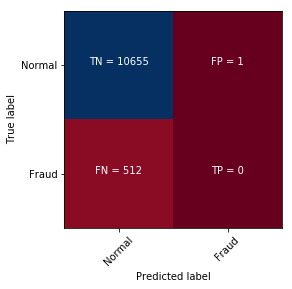

In [24]:
# This method simply plots confusion matrix with matplotlib.pyplot
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
    tn, fp, fn, tp = cm.ravel()
    
# Now, show our model
plot_cm(lgb_model, y_pred)

### Our guess is true!

We can see from the plot, the problem is `FALSE NEGATIVES`.

In [25]:
# We need imputing because, we have NaN values and SMOTE does not handle missing values.
imputer = SimpleImputer()
X_imputed = imputer.fit_transform(X)

# Our new dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_sample(X_imputed, y)

print(X_res.shape)
print(y_res.shape)

# Train and validation sets with new dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

(70978L, 135L)
(70978L,)


In [26]:
# Wow, we got equal number of classes!
(len(y_res) - np.count_nonzero(y_res)) / np.count_nonzero(y_res)

1

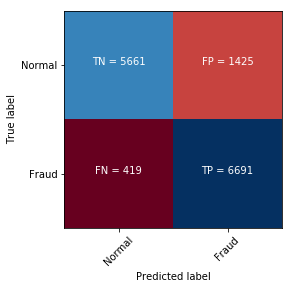

In [27]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
plot_cm(xgb_model, y_pred)

In [28]:
print(accuracy_score(y_test, y_pred))

0.8701042547196394


In [29]:
# Finding area under the curve with precision recall.
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

Average precision-recall score: 0.939


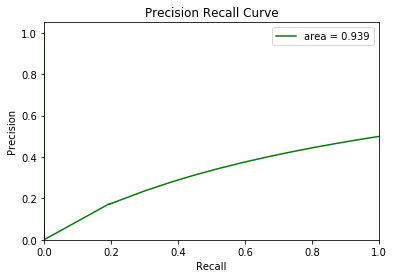

In [30]:
try:
    scores = xgb_model.decision_function(X_test)
except:
    scores = xgb_model.predict_proba(X_test)[:,1]

plot_aucprc(xgb_model, scores)

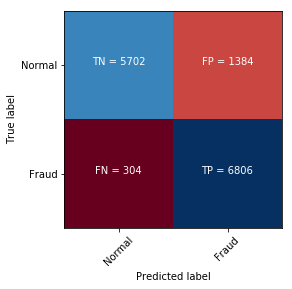

0.8810932657086503


In [31]:
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
try:
    scores = lgb_model.decision_function(X_test)
except:
    scores = lgb_model.predict_proba(X_test)[:,1]

# Make plots
plot_cm(lgb_model, y_pred)
print(accuracy_score(y_test, y_pred))

In [32]:
# This line takes feature_importances from LightGBM model and
# gives them the real name whatever they correspond to.
feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importances_,X.columns)), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp.Value > 30]

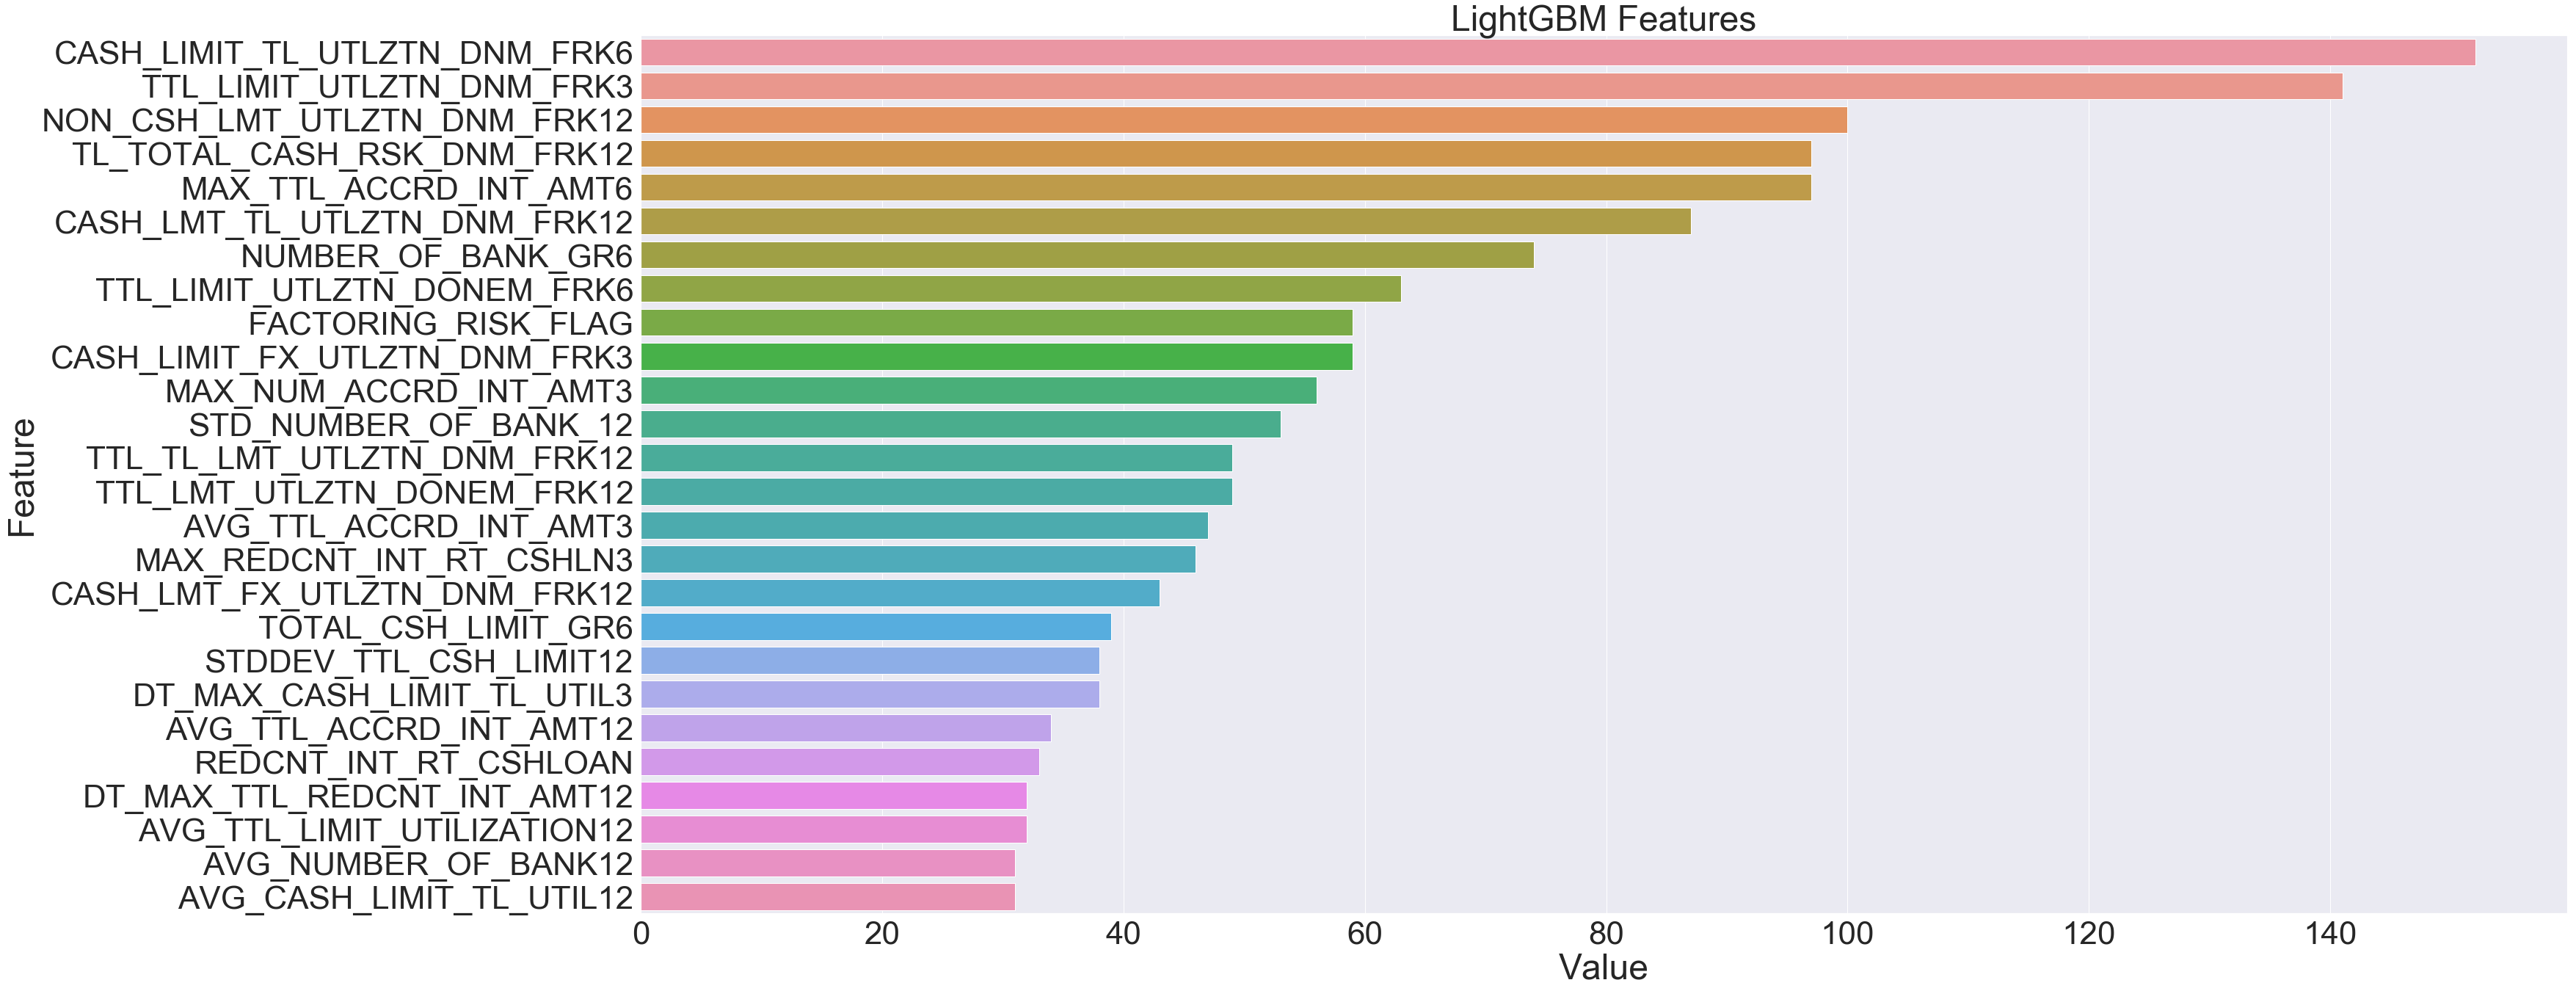

In [33]:
sns.set(font_scale=4)

plt.figure(figsize=(50, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

sns.set(font_scale=1)

In [34]:
# With Pickle serialization, I dumped the model
# which I can reload again.
with open('model.pkl', 'wb') as fout:
    pickle.dump(lgb_model, fout)

## Final Output

Here, we come to required output part. This will be a function which creates a table from given two arguments.

In [45]:
def model_output(csv_file):
    
    """
    Output function which receives .csv file then
    gives a table with two rows, namely IDs and probabilities.
    
    @param csv_file: csv file as a string.
    @return output_table: pandas DataFrame table.
    @raise FileNotFoundError: when file not finds exception.
    @raise NoPrimaryKeyError: when dataframe does not have a primary index column.
    """
    
    df = pd.read_csv(csv_file, delimiter=';')
    if 'DEFAULT_FLAG' in df:
        df = df.drop(columns=['DEFAULT_FLAG'])
    if 'PRIMARY_KEY' in df:
        primary_keys = df['PRIMARY_KEY']
        df = df.drop(columns=['PRIMARY_KEY'])
    else:
        raise Exception('No primary key column found!')
    with open('model.pkl', 'rb') as fin:
        pkl_bst = pickle.load(fin)
        
    # Find most correlated ones and drop.
    df = df.drop(columns=to_drop)
    
    # Find most missing ones over threshold 0.75 and drop.
    df = df.drop(columns=missing_columns)
    
    try:
        scores = pkl_bst.decision_function(df) * 1000
    except:
        scores = pkl_bst.predict_proba(df)[:,1] * 1000
        
    output_format = { 'Key': primary_keys, 'Skor': scores }
    table = pd.DataFrame(output_format)
    
    return table
    